# Import dataset

In [19]:
import turicreate as tc
import matplotlib.pyplot as plt

In [20]:
images_dir = "../../data/"
train_data = tc.image_analysis.load_images(images_dir + "train", with_path=True)
val_data = tc.image_analysis.load_images(images_dir + "val", with_path=True)
test_data = tc.image_analysis.load_images(images_dir + "test", with_path=True)

In [21]:
import os

train_data["label"] = train_data["path"].apply(lambda path: os.path.basename(os.path.split(path)[0]))
val_data["label"] = val_data["path"].apply(lambda path: os.path.basename(os.path.split(path)[0]))
test_data["label"] = test_data["path"].apply(lambda path: os.path.basename(os.path.split(path)[0]))

# Training

Available models:
- squeezenet_v1.1
- resnet-50

In [22]:
# model = tc.image_classifier.create(train_data,
#                                    validation_set=val_data,
#                                    target="label",
#                                    model="squeezenet_v1.1",
#                                    verbose=True,
#                                    max_iterations=100,
#                                    l2_penalty=10.0,
#                                    l1_penalty=0.0,
#                                    convergence_threshold=1e-8
#                                   )

In [23]:
# Extract and save features

from turicreate.toolkits import _pre_trained_models
from turicreate.toolkits import _image_feature_extractor

ptModel = _pre_trained_models.MODELS["squeezenet_v1.1"]()
feature_extractor = _image_feature_extractor.MXFeatureExtractor(ptModel)

train_features = feature_extractor.extract_features(train_data, "image", verbose=True)
extracted_train_features = tc.SFrame({"label": train_data["label"], "__image_features__": train_features})
extracted_train_features.save("train_features_tc.sframe")

val_features = feature_extractor.extract_features(val_data, "image", verbose=True)
extracted_val_features = tc.SFrame({"label": val_data["label"], "__image_features__": val_features})
extracted_val_features.save("val_features_tc.sframe")

Performing feature extraction on resized images...
Completed  64/879
Completed 128/879
Completed 192/879
Completed 256/879
Completed 320/879
Completed 384/879
Completed 448/879
Completed 512/879
Completed 576/879
Completed 640/879
Completed 704/879
Completed 768/879
Completed 832/879
Completed 879/879
Performing feature extraction on resized images...
Completed  64/110
Completed 110/110


In [24]:
lr_model = tc.logistic_classifier.create(extracted_train_features,
                                         features=["__image_features__"],
                                         target="label",
                                         validation_set=extracted_val_features,
                                         max_iterations=200,
                                         seed=None,
                                         verbose=True,
                                         l2_penalty=10.0,
                                         l1_penalty=0.0,
                                         convergence_threshold=1e-8
                                        )

Logistic regression:

--------------------------------------------------------

Number of examples          : 879

Number of classes           : 7

Number of feature columns   : 1

Number of unpacked features : 1000

Number of coefficients      : 6006

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 6        | 0.013408  | 0.100329     | 0.455063          | 0.454545            |

| 1         | 13       | 18.301496 | 0.299737     | 0.531286          | 0.545455            |

| 2         | 14       | 18.301496 | 0.339232     | 0.230944          | 0.236364            |

| 3         | 17       | 1.176360  | 0.403059     | 0.546075          | 0.545455            |

| 4         | 18       | 1.176360  | 0.444365     | 0.604096          | 0.609091            |

| 9         | 32       | 0.878108  | 0.925361     | 0.810011          | 0.809091            |

| 49        | 102      | 2.468162  | 3.550077     | 0.959044          | 0.936364            |

| 99        | 177      | 1.000000  | 6.887211     | 0.967008          | 0.936364            |

| 149       | 246      | 1.000000  | 9.700310     | 0.968146          | 0.945455            |

| 199       | 331      | 1.000000  | 13.818084    | 0.967008          | 0.936364            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

In [25]:
from turicreate.toolkits.image_classifier import ImageClassifier

state = {
    'classifier': lr_model,
    'model': ptModel.name,
    'max_iterations': lr_model.max_iterations,
    'feature_extractor': feature_extractor,
    'input_image_shape': ptModel.input_image_shape,
    'target': lr_model.target,
    'feature': 'image',
    'num_features': 1,
    'num_classes': lr_model.num_classes,
    'classes': lr_model.classes,
    'num_examples': lr_model.num_examples,
    'training_time': lr_model.training_time,
    'training_loss': lr_model.training_loss
}

model = ImageClassifier(state)

# Testing

In [26]:
metrics = model.evaluate(test_data)

Performing feature extraction on resized images...
Completed  64/110
Completed 110/110


/Applications/anaconda3/envs/turienv/lib/python3.7/site-packages/turicreate/aggregate.py:91: UserWarning: Passing parameter(s) to COUNT is deprecated. This functionality will be removed in the next major release. Any passed parameters are ignored.
  warnings.warn('Passing parameter(s) to COUNT is deprecated. This functionality will be removed in '


In [27]:
output = model.classify(test_data)

In [28]:
predictions = model.predict(test_data, output_type="probability_vector")

In [29]:
imgs_with_pred = test_data.add_columns(output)
imgs_filtered = imgs_with_pred[(imgs_with_pred["probability"] > 0.9) & (imgs_with_pred["label"] != imgs_with_pred["class"])]

In [30]:
import numpy as np
import seaborn as sns

def compute_confusion_matrix(metrics, labels):
    num_labels = len(labels)
    label_to_index = {l:i for i,l in enumerate(labels)}
    
    conf = np.zeros((num_labels, num_labels), dtype=np.int)
    for row in metrics["confusion_matrix"]:
        true_label = label_to_index[row["target_label"]]
        pred_label = label_to_index[row["predicted_label"]]
        conf[true_label, pred_label] = row["count"]
        
    return conf

def plot_confusion_matrix(conf, labels, figsize=(8, 8)):
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(conf, annot=True, fmt="d")
    heatmap.xaxis.set_ticklabels(labels, rotation=45, ha="right", fontsize=12)
    heatmap.yaxis.set_ticklabels(labels, rotation=0, ha="right", fontsize=12)
    plt.xlabel("Predicted label", fontsize=12)
    plt.ylabel("True label", fontsize=12)
    plt.show()

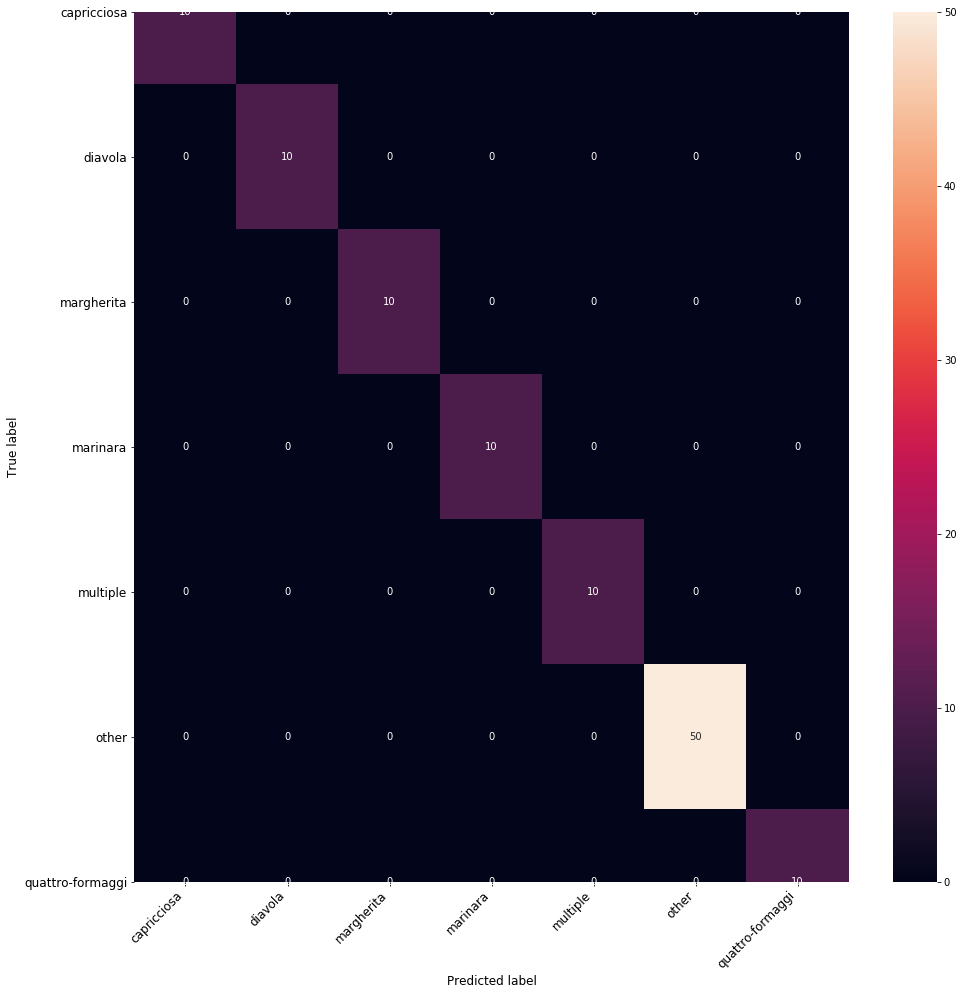

In [31]:
labels = test_data["label"].unique().sort()
conf = compute_confusion_matrix(metrics, labels)
plot_confusion_matrix(conf, labels, figsize=(16, 16))

In [32]:
for i, label in enumerate(labels):
    correct = conf[i, i]
    images_per_class = conf[i].sum()
    print("%10s %.1f%%" % (label, 100. * correct/images_per_class))

capricciosa 100.0%
   diavola 100.0%
margherita 100.0%
  marinara 100.0%
  multiple 100.0%
     other 100.0%
quattro-formaggi 100.0%


In [33]:
class2index = {v:k for k,v in enumerate(test_data["label"].unique().sort())}
predicted_labels = np.argmax(predictions, axis=-1)
target_labels = list(map(lambda l: class2index[l], test_data["label"]))

In [34]:
# Find for which images the predicted class is wrong
wrong_images = np.where(predicted_labels != target_labels)[0]

# For every prediction, find the largest probability value;
# this is the probability of the winning class for this image
probs_max = np.max(np.array(predictions), axis=-1)

# Sort the probabilities from the wrong images from low to high
idx = np.argsort(probs_max[wrong_images])

# Reverse the order (high to low), and keep the 5 highest ones
idx = idx[::-1][:5]

# Get the indices of the images with the worst predictions
worst_predictions = wrong_images[idx]

index2class = {k:v for k,v in enumerate(test_data["label"].unique().sort())}

for i in worst_predictions:
    print("%s was predicted as '%s' %.4f" % (test_data["path"][i],
                                             index2class[predicted_labels[i]],
                                             probs_max[i]))

# Convertion

In [35]:
model.save("Pizza_tc.model")

In [36]:
model.export_coreml("Pizza_tc.mlmodel")